Total Variation Denoising (ADMM)
================================

This example compares denoising via isotropic and anisotropic total
variation (TV) regularization <cite data-cite="rudin-1992-nonlinear"/>
<cite data-cite="goldstein-2009-split"/>. It solves the denoising problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - \mathbf{x}
  \|_2^2 + \lambda R(\mathbf{x}) \;,$$

where $R$ is either the isotropic or anisotropic TV regularizer.
In SCICO, switching between these two regularizers is a one-line
change: replacing an
[L1Norm](../_autosummary/scico.functional.rst#scico.functional.L1Norm)
with a
[L21Norm](../_autosummary/scico.functional.rst#scico.functional.L21Norm).
Note that the isotropic version exhibits fewer block-like artifacts on
edges that are not vertical or horizontal.

In [1]:
from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, plot
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 256  # image size
phantom = SiemensStar(16)
x_gt = snp.pad(discrete_phantom(phantom, N - 16), 8)
x_gt = x_gt / x_gt.max()

Add noise to create a noisy test image.

In [3]:
σ = 0.75  # noise standard deviation
noise, key = scico.random.randn(x_gt.shape, seed=0)
y = x_gt + σ * noise

Denoise with isotropic total variation.

In [4]:
λ_iso = 1.4e0
f = loss.SquaredL2Loss(y=y)
g_iso = λ_iso * functional.L21Norm()

# The append=0 option makes the results of horizontal and vertical finite
# differences the same shape, which is required for the L21Norm.
C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
solver = ADMM(
    f=f,
    g_list=[g_iso],
    C_list=[C],
    rho_list=[1e1],
    x0=y,
    maxiter=100,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 20}),
    itstat_options={"display": True, "period": 10},
)

print(f"Solving on {device_info()}\n")
solver.solve()
x_iso = solver.x
print()

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  2.91e+00  1.086e+05  1.130e+02  7.375e+02      0  0.000e+00


  10  3.89e+00  3.911e+04  1.613e+01  4.388e+02     12  8.974e-04


  20  4.24e+00  2.333e+04  9.468e+00  1.396e+02     15  8.943e-04


  30  4.52e+00  2.228e+04  2.691e+00  2.984e+01     11  9.646e-04


  40  4.74e+00  2.225e+04  1.089e+00  6.712e+00      7  9.354e-04


  50  4.89e+00  2.226e+04  6.779e-01  2.817e+00      6  9.496e-04
  60  5.02e+00  2.226e+04  4.808e-01  1.298e+00      3  8.914e-04


  70  5.12e+00  2.227e+04  3.566e-01  8.595e-01      2  8.337e-04
  80  5.21e+00  2.227e+04  2.788e-01  6.620e-01      2  9.770e-04


  90  5.31e+00  2.227e+04  2.407e-01  4.794e-01      5  8.334e-04
  99  5.38e+00  2.227e+04  1.948e-01  1.765e-01      1  9.823e-04



Denoise with anisotropic total variation for comparison.

In [5]:
# Tune the weight to give the same data fidelity as the isotropic case.
λ_aniso = 1.2e0
g_aniso = λ_aniso * functional.L1Norm()

solver = ADMM(
    f=f,
    g_list=[g_aniso],
    C_list=[C],
    rho_list=[1e1],
    x0=y,
    maxiter=100,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 20}),
    itstat_options={"display": True, "period": 10},
)

solver.solve()
x_aniso = solver.x
print()

Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  3.79e-01  1.165e+05  1.330e+02  8.477e+02      0  0.000e+00


  10  7.20e-01  3.707e+04  2.212e+01  4.390e+02     13  9.291e-04


  20  1.01e+00  2.302e+04  9.601e+00  1.202e+02     15  8.581e-04


  30  1.27e+00  2.226e+04  2.706e+00  2.652e+01     11  8.191e-04


  40  1.46e+00  2.224e+04  1.132e+00  7.486e+00      7  9.416e-04


  50  1.59e+00  2.224e+04  6.684e-01  3.664e+00      3  9.745e-04
  60  1.71e+00  2.224e+04  4.317e-01  2.308e+00      2  8.436e-04


  70  1.85e+00  2.225e+04  3.064e-01  1.535e+00      2  6.615e-04
  80  1.93e+00  2.225e+04  2.309e-01  1.122e+00      2  7.092e-04


  90  2.04e+00  2.225e+04  1.887e-01  7.174e-01      1  8.656e-04
  99  2.12e+00  2.225e+04  1.652e-01  3.941e-01      1  9.124e-04



Compute and print the data fidelity.

In [6]:
for x, name in zip((x_iso, x_aniso), ("Isotropic", "Anisotropic")):
    df = f(x)
    print(f"Data fidelity for {name} TV was {df:.2e}")

Data fidelity for Isotropic TV was 1.93e+04
Data fidelity for Anisotropic TV was 1.92e+04


Plot results.

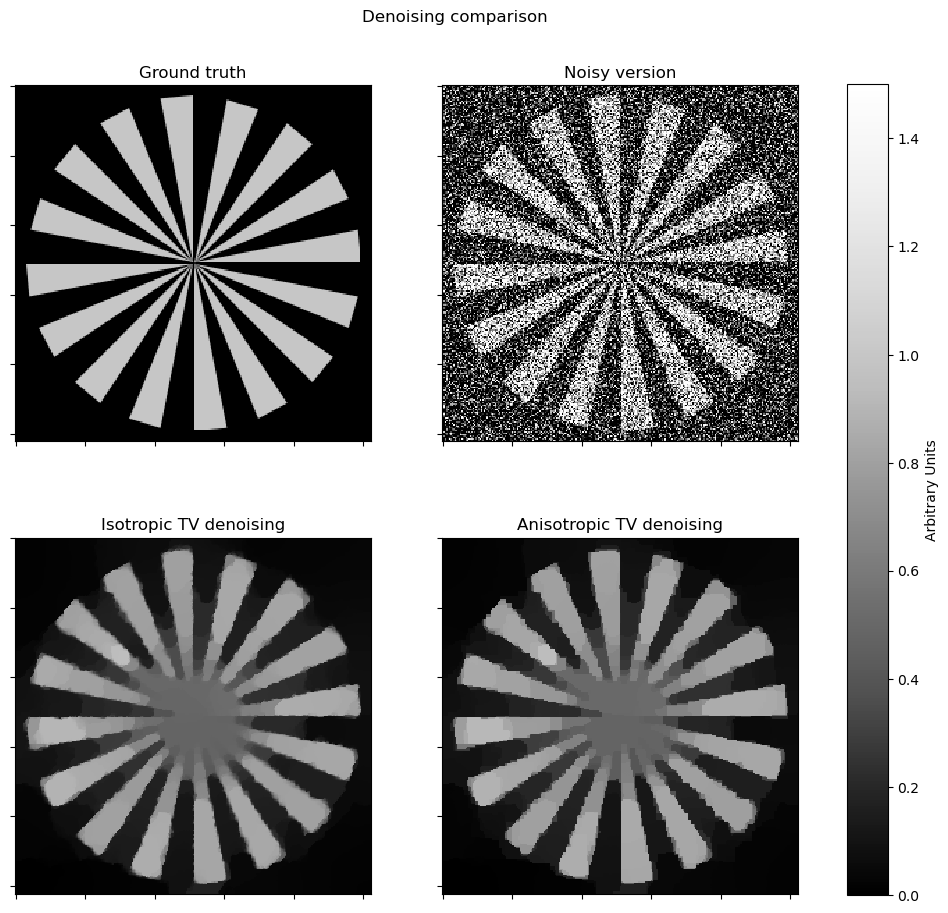

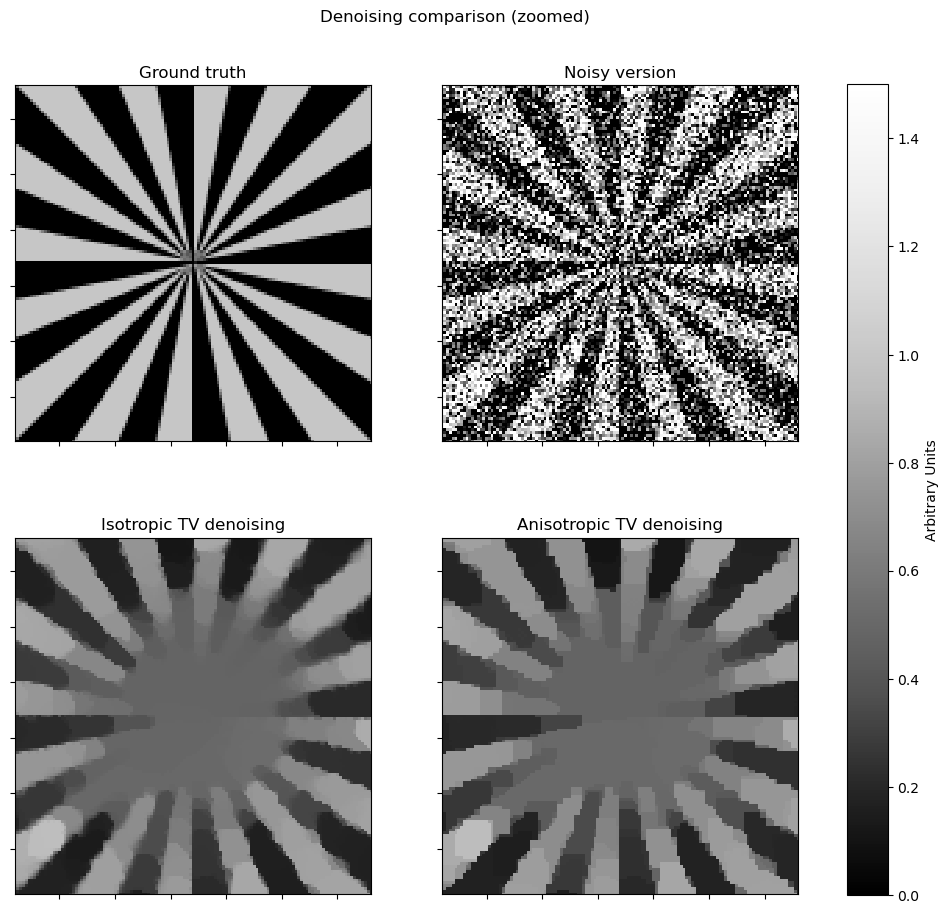

In [7]:
plt_args = dict(norm=plot.matplotlib.colors.Normalize(vmin=0, vmax=1.5))
fig, ax = plot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(y, title="Noisy version", fig=fig, ax=ax[0, 1], **plt_args)
plot.imview(x_iso, title="Isotropic TV denoising", fig=fig, ax=ax[1, 0], **plt_args)
plot.imview(x_aniso, title="Anisotropic TV denoising", fig=fig, ax=ax[1, 1], **plt_args)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="Arbitrary Units"
)
fig.suptitle("Denoising comparison")
fig.show()

# zoomed version
fig, ax = plot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(y, title="Noisy version", fig=fig, ax=ax[0, 1], **plt_args)
plot.imview(x_iso, title="Isotropic TV denoising", fig=fig, ax=ax[1, 0], **plt_args)
plot.imview(x_aniso, title="Anisotropic TV denoising", fig=fig, ax=ax[1, 1], **plt_args)
ax[0, 0].set_xlim(N // 4, N // 4 + N // 2)
ax[0, 0].set_ylim(N // 4, N // 4 + N // 2)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="Arbitrary Units"
)
fig.suptitle("Denoising comparison (zoomed)")
fig.show()